### Reading in Color Images

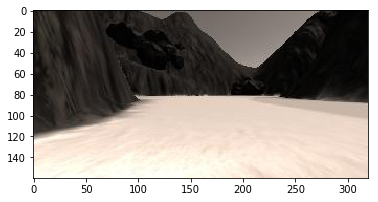

In [4]:
#has to be before import
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

filename = "sample.jpg"
image = mpimg.imread(filename)
plt.imshow(image)
plt.show()

#### Masks Test

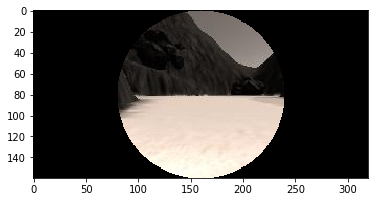

In [3]:
#Don't run this part of code normally
nrows, ncols, nlayers = image.shape
row, col = np.ogrid[:nrows, :ncols]
cnt_row, cnt_col = nrows / 2, ncols / 2
outer_disk_mask = ((row - cnt_row)**2 + (col - cnt_col)**2 > (nrows / 2)**2)
image[outer_disk_mask] = 0
plt.imshow(image)
plt.show()

In [13]:
print(image.dtype, image.shape, np.min(image), np.max(image))

uint8 (160, 320, 3) 0 255


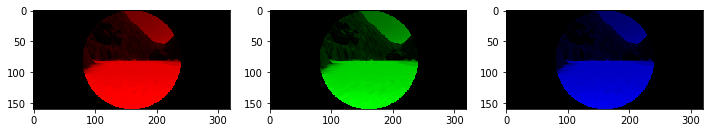

In [14]:
# Note: we use the np.copy() function rather than just saying red_channel = image
# because in Python, such a statement would set those two arrays equal to each other
# forever, meaning any changes made to one would also be made to the other!
red_channel = np.copy(image)
# Note: here instead of extracting individual channels from the image
# I'll keep all 3 color channels in each case but set the ones I'm not interested 
# in to zero.  
red_channel[:,:,[1, 2]] = 0 # Zero out the green and blue channels
green_channel = np.copy(image)
green_channel[:,:,[0, 2]] = 0 # Zero out the red and blue channels
blue_channel = np.copy(image)
blue_channel[:,:,[0, 1]] = 0 # Zero out the red and green channels
fig = plt.figure(figsize=(12,3)) # Create a figure for plotting
plt.subplot(131) # Initialize subplot number 1 in a figure that is 3 columns 1 row
plt.imshow(red_channel) # Plot the red channel
plt.subplot(132) # Initialize subplot number 2 in a figure that is 3 columns 1 row
plt.imshow(green_channel)  # Plot the green channel
plt.subplot(133) # Initialize subplot number 3 in a figure that is 3 columns 1 row
plt.imshow(blue_channel)  # Plot the blue channel
plt.show() 

### Color Thresholding

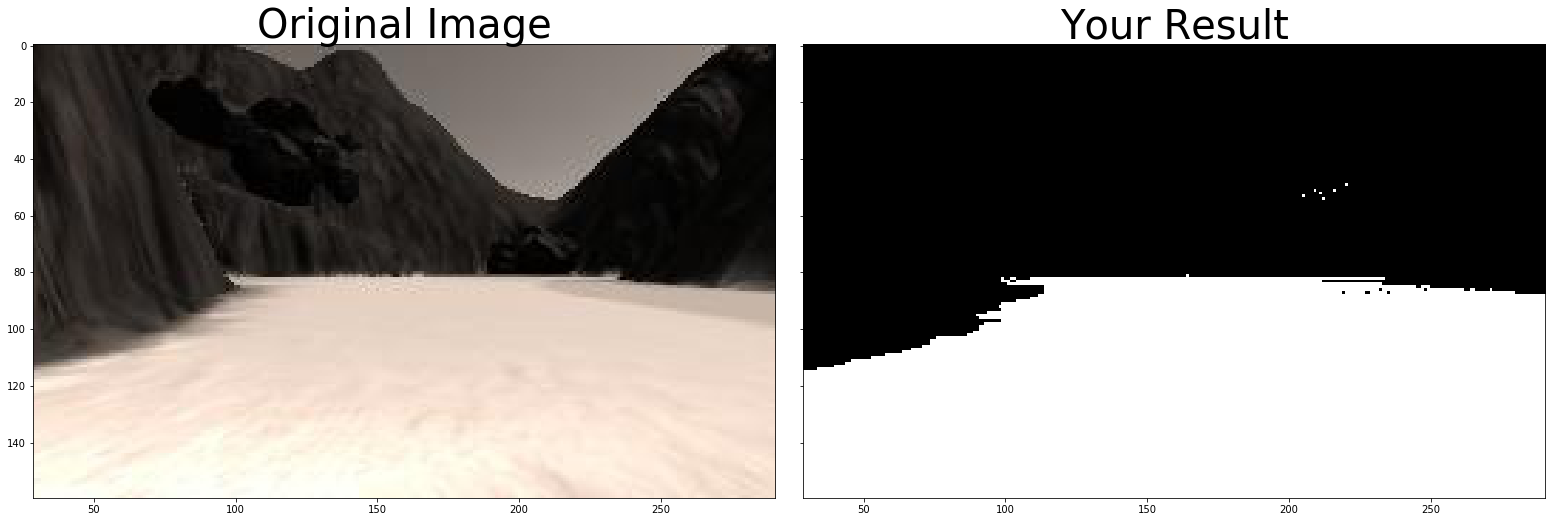

In [5]:
# Define a function to perform a color threshold
def color_thresh(img, rgb_thresh=(0, 0, 0)):
    ###### TODO:
    # Create an empty array the same size in x and y as the image 
    # but just a single channel
    color_select = np.zeros_like(img[:,:,0])
    # Apply the thresholds for RGB and assign 1's 
    # where threshold was exceeded
    # Return the single-channel binary image
    thresh = (img[:,:,0] > rgb_thresh[0]) \
            & (img[:,:,1] > rgb_thresh[1]) \
            & (img[:,:,2] > rgb_thresh[2])
    color_select[thresh] = 1
    return color_select
    
# Define color selection criteria
###### TODO: MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
red_threshold = 160
green_threshold = 160
blue_threshold = 160
######
rgb_threshold = (red_threshold, green_threshold, blue_threshold)

# pixels below the thresholds
colorsel = color_thresh(image, rgb_thresh=rgb_threshold)

# Display the original image and binary               
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 7), sharey=True)
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(colorsel, cmap='gray')
ax2.set_title('Your Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Perspective Transform

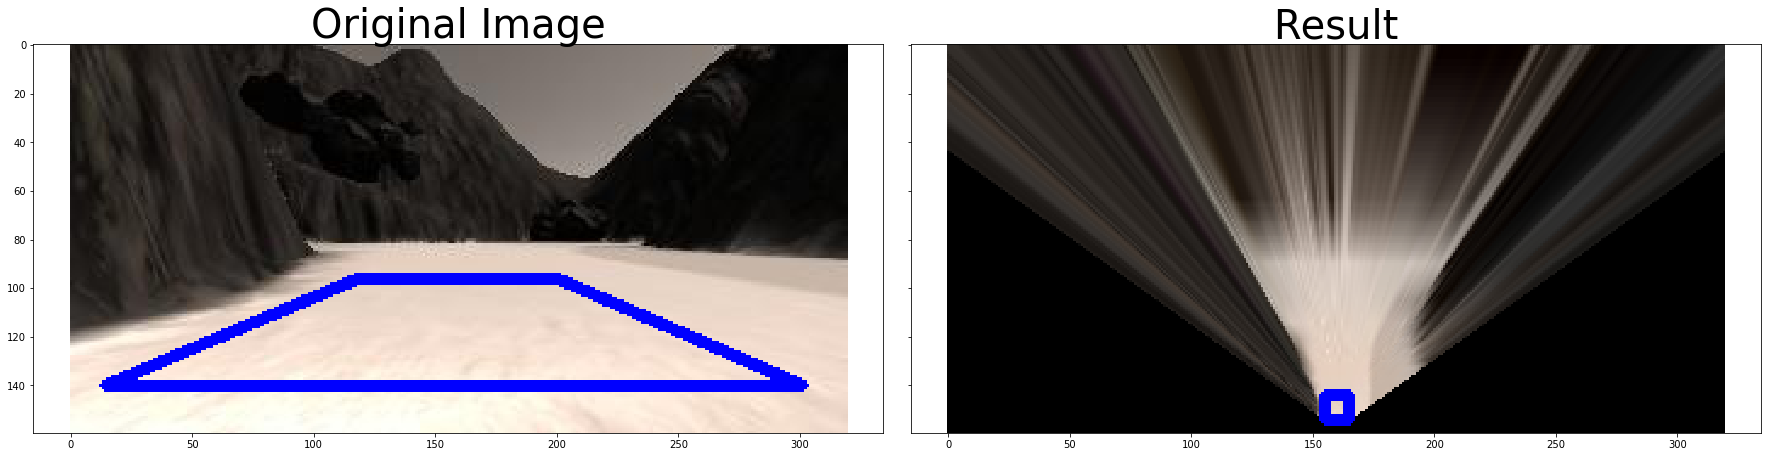

In [6]:
def perspect_transform(img, src, dst):

    # Get transform matrix using cv2.getPerspectivTransform()
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp image using cv2.warpPerspective()
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    # Return the result
    return warped

dst_size = 5 
bottom_offset = 6
# Define source and destination points
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(image, source, destination)
# Draw Source and destination points on images (in blue) before plotting
cv2.polylines(image, np.int32([source]), True, (0, 0, 255), 3)
cv2.polylines(warped, np.int32([destination]), True, (0, 0, 255), 3)
# Display the original image and binary               
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped, cmap='gray')
ax2.set_title('Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.show() # Uncomment if running on your local machine

## Test Until Now

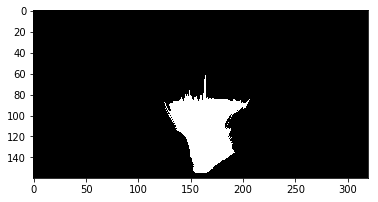

In [8]:
# Read in the same sample image as before
image = mpimg.imread('sample.jpg')

# Assume you have already defined perspect_transform() and color_thresh()
warped = perspect_transform(image, source, destination)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))

# Plot the result
plt.imshow(colorsel, cmap='gray')
plt.show() 

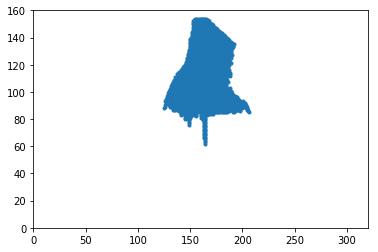

In [9]:
ypos, xpos = colorsel.nonzero()
plt.plot(xpos, ypos, '.')
plt.xlim(0, 320)
plt.ylim(0, 160)
plt.show() 

## Warp

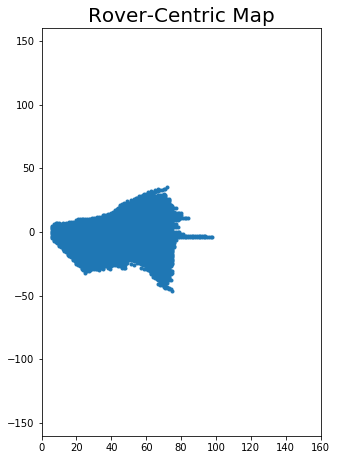

In [13]:
# Read in the sample image
image = mpimg.imread('sample.jpg')


def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Perform warping and color thresholding
warped = perspect_transform(image, source, destination)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))
# Extract x and y positions of navigable terrain pixels
# and convert to rover coordinates
xpix, ypix = rover_coords(colorsel)

# Plot the map in rover-centric coords
fig = plt.figure(figsize=(5, 7.5))
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
plt.title('Rover-Centric Map', fontsize=20)
#plt.show() # Uncomment if running on your local machine

## Map to World Coordinates

Xpos = [ 102.20385074] Ypos = [ 32.69503415] Yaw = [ 327.85502116]


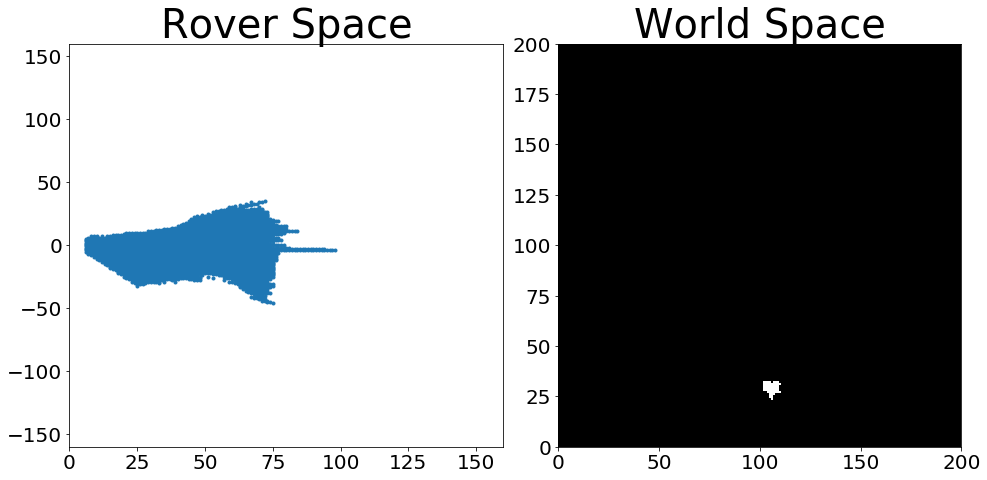

In [19]:
# Read in the sample image
image = mpimg.imread('sample.jpg')

# Rover yaw values will come as floats from 0 to 360
# Generate a random value in this range
# Note: you need to convert this to radians
    # before adding to pixel_angles
rover_yaw = np.random.random(1)*360

# Generate a random rover position in world coords
# Position values will range from 20 to 180 to 
# avoid the edges in a 200 x 200 pixel world
rover_xpos = np.random.random(1)*160 + 20
rover_ypos = np.random.random(1)*160 + 20

# Note: Since we've chosen random numbers for yaw and position, 
# multiple run of the code will result in different outputs each time.

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # TODO:
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    # Apply a rotation
    xpix_rotated = xpix*np.cos(yaw_rad) - ypix*np.sin(yaw_rad)
    ypix_rotated = xpix * np.sin(yaw_rad) + ypix * np.cos(yaw_rad)
    # Return the result  
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # TODO:
    # Apply a scaling and a translation
    xpix_translated = np.int_(xpos + (xpix_rot / scale))
    ypix_translated = np.int_(ypos + (ypix_rot / scale))
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Clip to world_size
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# No need to modify code below here
# Perform warping and color thresholding
##########
# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(image, source, destination)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))
# Extract navigable terrain pixels
xpix, ypix = rover_coords(colorsel)
# Generate 200 x 200 pixel worldmap
worldmap = np.zeros((200, 200))
scale = 10
# Get navigable pixel positions in world coords
x_world, y_world = pix_to_world(xpix, ypix, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                worldmap.shape[0], scale)
# Add pixel positions to worldmap
worldmap[y_world, x_world] += 1
print('Xpos =', rover_xpos, 'Ypos =', rover_ypos, 'Yaw =', rover_yaw)
# Plot the map in rover-centric coords

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
f.tight_layout()
ax1.plot(xpix, ypix, '.')
ax1.set_title('Rover Space', fontsize=40)
ax1.set_ylim(-160, 160)
ax1.set_xlim(0, 160)
ax1.tick_params(labelsize=20)

ax2.imshow(worldmap, cmap='gray')
ax2.set_title('World Space', fontsize=40)
ax2.set_ylim(0, 200)
ax2.tick_params(labelsize=20)
ax2.set_xlim(0, 200)


plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.1)
#plt.show() # Uncomment if running on your local machine